In [20]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from scipy import stats
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans,AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

# display settings
pd.set_option('display.max_column',None)
plt.rcParams['figure.figsize']=(8,5)



In [7]:
# load dataset
path='/content/Mall_Customers.csv'     #colab:upload this path or change
df=pd.read_csv(path)
print('data loaded.shape:',df.shape)
df.head()

data loaded.shape: (200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [8]:

# Basic EDA
print('\n --- Info ---')
display(df.info())
print('\n --- missing value ---')
display(df.isnull().sum())
print('\n---summary statistics----')
display(df.describe(include='all'))

#rename columns for convenience if needed
df=df.rename(columns=lambda x: x.strip().replace(' ','_').replace('(','').replace(')',''))
df.columns



 --- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None


 --- missing value ---


,0
CustomerID,0
Genre,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0



---summary statistics----


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


Index(['CustomerID', 'Genre', 'Age', 'Annual_Income_k$',
       'Spending_Score_1-100'],
      dtype='object')

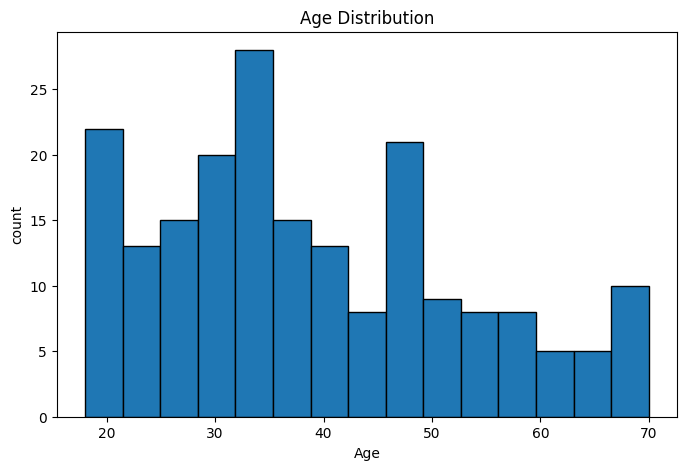

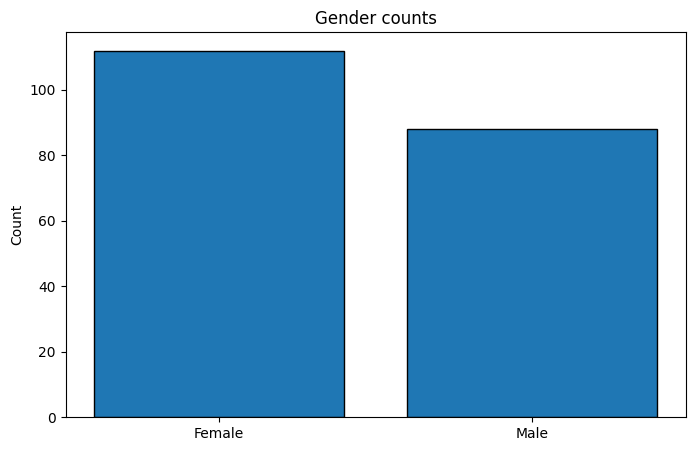

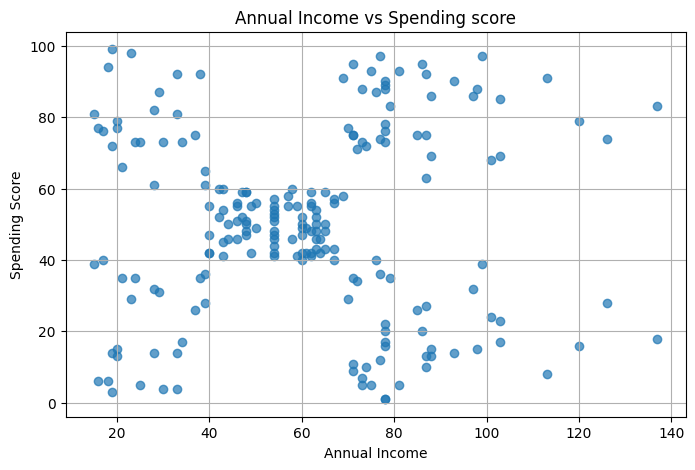

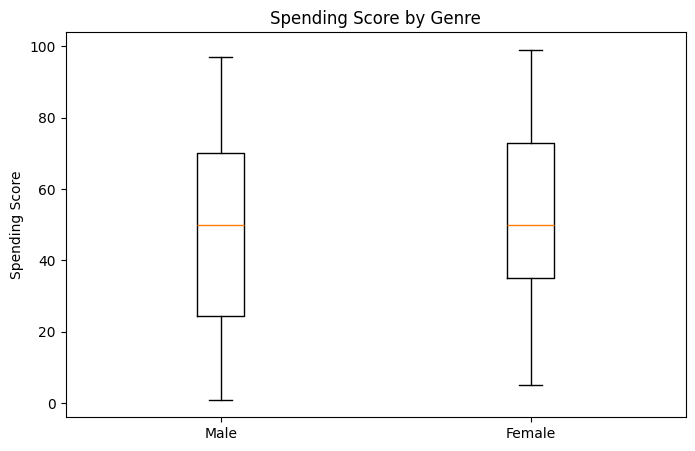

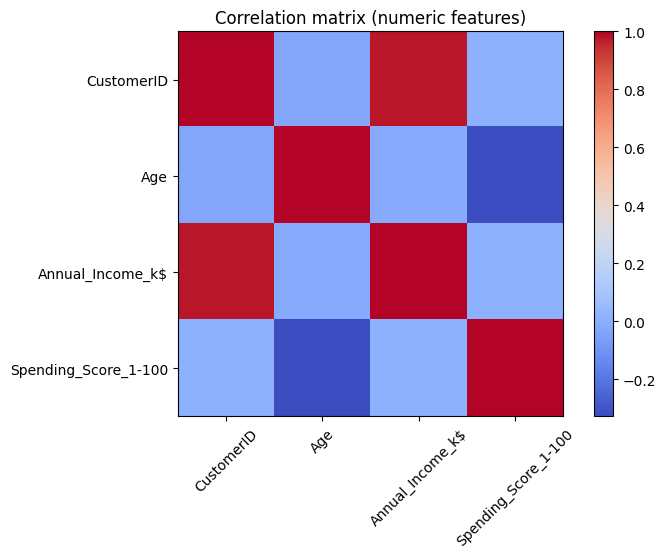

In [9]:
#visulizations (matlotlib)
#1) age distribution
# plot histogram
plt.figure()
plt.hist(df['Age'],bins=15,edgecolor='k')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('count')
plt.show()


#2) Gender counts
plt.figure()
g_counts = df['Genre'].value_counts()
plt.bar(g_counts.index, g_counts.values, edgecolor='k')
plt.title('Gender counts')
plt.ylabel('Count')
plt.show()



#3) scatter plot annual income vs spending
plt.figure()
plt.scatter(df['Annual_Income_k$'],df['Spending_Score_1-100'],alpha=0.7)
plt.title('Annual Income vs Spending score')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.grid(True)
plt.show()


# 4) Boxplot of Spending Score by Gender
plt.figure()
male_scores = df[df['Genre']=='Male']['Spending_Score_1-100']
female_scores = df[df['Genre']=='Female']['Spending_Score_1-100']
plt.boxplot([male_scores, female_scores], labels=['Male','Female'])
plt.title('Spending Score by Genre')
plt.ylabel('Spending Score')
plt.show()


# 5) Correlation heatmap (using imshow)
plt.figure()
numeric = df.select_dtypes(include=np.number)
corr = numeric.corr()
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation matrix (numeric features)')
plt.show()



In [10]:
# Hypothesis testing examples

# 1) Two-sample t-test: Do males and females have different mean spending scores?
males = df[df['Genre']=='Male']['Spending_Score_1-100']
females = df[df['Genre']=='Female']['Spending_Score_1-100']

# Check assumptions quickly: approximate normality (visual) and similar variances (Levene)
levene_stat, levene_p = stats.levene(males, females)
t_stat, t_p = stats.ttest_ind(males, females, equal_var=(levene_p>0.05))

print('Levene test for equal variances: stat={:.3f}, p={:.3f}'.format(levene_stat, levene_p))
print("Two-sample t-test (Male vs Female spending score): t={:.3f}, p={:.4f}".format(t_stat, t_p))
if t_p < 0.05:
    print('Result: Reject null — significant difference in mean spending score between genders.')
else:
    print('Result: Fail to reject null — no significant difference detected.')

Levene test for equal variances: stat=2.343, p=0.127
Two-sample t-test (Male vs Female spending score): t=-0.819, p=0.4137
Result: Fail to reject null — no significant difference detected.


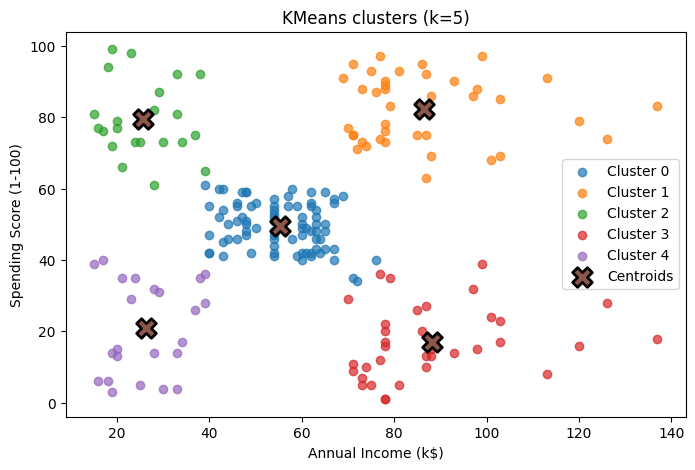

,count
Cluster,
0,81
1,39
2,22
3,35
4,23


In [11]:

# Quick clustering example — KMeans segmentation using 'Annual Income' and 'Spending Score'
X = df[['Annual_Income_k$','Spending_Score_1-100']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use K=5 as common in segmentation examples; you can vary K and inspect inertia/elbow method
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)
df['Cluster'] = labels

# Plot clusters (original scale)
plt.figure()
for c in np.unique(labels):
    mask = labels == c
    plt.scatter(df.loc[mask,'Annual_Income_k$'], df.loc[mask,'Spending_Score_1-100'], label=f'Cluster {c}', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:,0]*scaler.scale_[0] + scaler.mean_[0],
            kmeans.cluster_centers_[:,1]*scaler.scale_[1] + scaler.mean_[1],
            marker='X', s=200, linewidths=2, edgecolor='k', label='Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('KMeans clusters (k=5)')
plt.legend()
plt.show()

# Show cluster counts
display(df['Cluster'].value_counts().sort_index())

In [13]:
# label_encoder = LabelEncoder()
# df['Genre'] = label_encoder.fit_transform(df['Genre'])

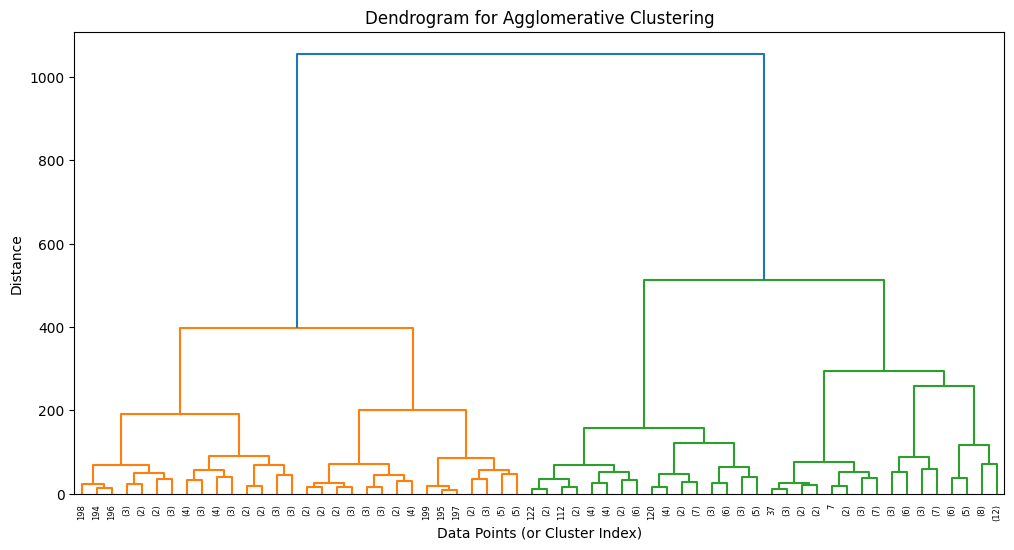

In [16]:
label_encoder = LabelEncoder()
df['Genre'] = label_encoder.fit_transform(df['Genre'])
Z = linkage(df, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Data Points (or Cluster Index)')
plt.ylabel('Distance')
plt.show()

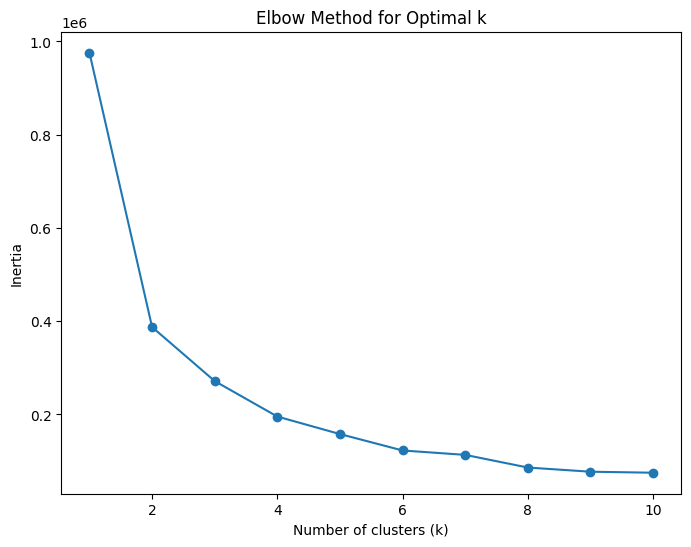

In [17]:
inertia=[]
k_range = range(1, 11)

for k in k_range:
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8,6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [18]:
kmeans=KMeans(n_clusters=5,random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(df)
kmeans_score = silhouette_score(df, kmeans.labels_)
print(f"K-Means Silhouette Score: {kmeans_score:.2f}")

K-Means Silhouette Score: 0.44


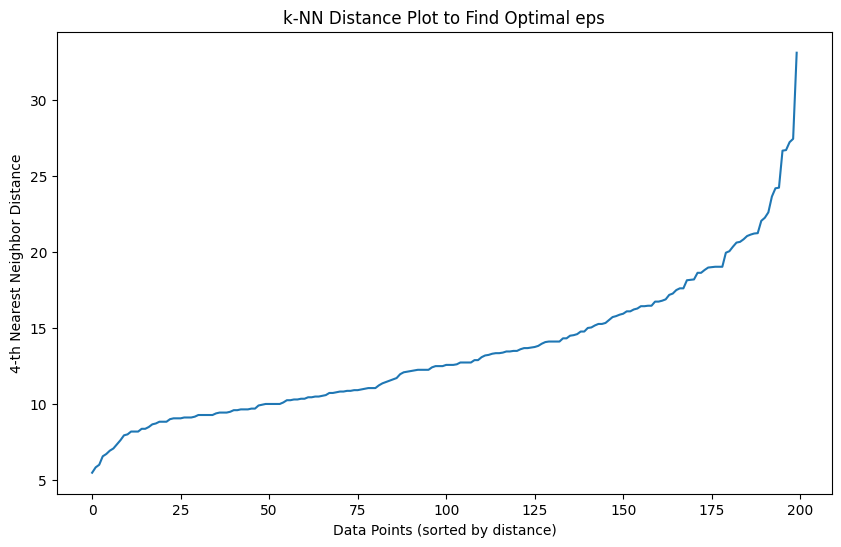

In [19]:
k=4
nearest_neighbors=NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(df)

distances,indices=nearest_neighbors.kneighbors(df)

k_distances= np.sort(distances[:, k - 1])

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title('k-NN Distance Plot to Find Optimal eps')
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.show()